In [33]:
# imports
import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm

In [34]:
# Load the accounting data
accounting_data = pd.read_excel('DataLab3accounting.xlsx')
print("Accounting Data:")
print(accounting_data.head())

# Load the stock prices data
prices_data = pd.read_excel('DataLab3prices.xlsx')
# ensure the dates are actually dates
prices_data['Date'] = pd.to_datetime(prices_data['Date'], format='%Y%m%d')
print("\nPrices Data:")
print(prices_data.head())

# Load the risk-free rate data
rf_data = pd.read_excel('DataLab3rf.xlsx')
# ensure it is a date object
rf_data['Date'] = pd.to_datetime(rf_data['Date'], format='%Y%m')
print("\nRisk-Free Rate Data:")
print(rf_data)

Accounting Data:
    CUSIP     LCT     DLTT    CSHO  fyear
0  307108  34.337  140.335  22.814   2015

Prices Data:
   Cusip       Date  Prices
0  30710 2015-01-02   30.21
1  30710 2015-01-05   29.73
2  30710 2015-01-06   29.38
3  30710 2015-01-07   28.64
4  30710 2015-01-08   29.37

Risk-Free Rate Data:
         Date  Riskfree
0  2015-01-01      0.00
1  2015-02-01      0.00
2  2015-03-01      0.00
3  2015-04-01      0.00
4  2015-05-01      0.00
5  2015-06-01      0.00
6  2015-07-01      0.00
7  2015-08-01      0.00
8  2015-09-01      0.00
9  2015-10-01      0.00
10 2015-11-01      0.00
11 2015-12-01      0.01


In [35]:
# assign each risk_free rate to each price
risk_free_per_date = []

# Initialize a pointer for the risk-free rate data
rf_index = 0

# Loop through each price date
for price_date in prices_data['Date']:
    # If there is a next risk-free date and the price date has reached or passed it,
    # update the pointer to use the new risk-free rate.
    if rf_index < len(rf_data) - 1:
        rf_date = rf_data['Date'].iloc[rf_index + 1]
        # If the current price_date is on or after the next risk-free date,
        # increment the pointer.
        if price_date.month >= rf_date.month:
            rf_index += 1
    # Append the risk-free rate corresponding to the current pointer
    risk_free_per_date.append(rf_data['Riskfree'].iloc[rf_index])

# setting it up for easy retrieval later
prices_data['Riskfree'] = risk_free_per_date


In [48]:
# Save the number of shares outstanding and convert to actual count (multiplied by 10^6)
nbr_shares = int(accounting_data['CSHO'].iloc[0]*1e6)
print(f"Number of Shares Outstanding: {nbr_shares:,}")

# Calculate the market value of equity (E0) for each date:
# This is the share price multiplied by the number of shares outstanding.
prices_data['E0'] = prices_data['Prices'] * nbr_shares
print("Calculated market value of equity (E0) for each date.")

# Extract and scale short-term debt (STD) from accounting data (in USD)
STD = accounting_data['LCT'].iloc[0]*1e6
print(f"Short-Term Debt (STD): ${STD:,.2f}")

# Extract and scale long-term debt (LTD) from accounting data (in USD)
LTD = accounting_data['DLTT'].iloc[0]*1e6
print(f"Long-Term Debt (LTD): ${LTD:,.2f}")

# Calculate the equity returns using the percentage change of stock prices.
prices_data['Return'] = prices_data['Prices'].pct_change()

# Drop any missing values that result from the percentage change calculation.
prices_data.dropna(subset=['Return'], inplace=True)
print("Calculated equity returns and removed missing values.")

# Compute the sample equity volatility (σ_E) using the returns.
# Using ddof=1 to ensure we're using the unbiased estimator (sample standard deviation).
sigma_E = np.std(prices_data['Return'], ddof=1)
print(f"Sample Equity Volatility: {sigma_E*100:.2f}%")

Number of Shares Outstanding: 22,814,000
Calculated market value of equity (E0) for each date.
Short-Term Debt (STD): $34,337,000.00
Long-Term Debt (LTD): $140,335,000.00
Calculated equity returns and removed missing values.
Sample Equity Volatility: 4.09%


In [49]:
# function to calculate the total debt
def calculate_total_debt(k):
    return STD+k*LTD

# function that gives d_1 and d_2
def ds(V, sigma_V, K, T):
    d_1 = np.log(V/K) + (r+sigma_V**2 / 2) * T
    d_2 = d_1-sigma_V * np.sqrt(T)
    return d_1,d_2

# function to calculte probability of default
def calc_PD(V, sigma_V, K, T):
    _,d_2 = ds(V, sigma_V, K, T)
    PD = norm.cdf(-d_2)
    return PD

# objective function to solve on
def merton_equations(params, E, sigma_E, K, r, T):
    # params[0] is total asset value
    # params[1] is the volatility for asset
    V, sigma_V = params

    # Calculate d1 and d2
    d_1, d_2 = ds(V, sigma_V, K, T)

    # Merton model equations, setup so we can use python fsolve later
    eq1 = V * norm.cdf(d_1) - K * np.exp(-r * T) * norm.cdf(d_2) - E
    eq2 = V * sigma_V * norm.cdf(d_1) - sigma_E * E
    return [eq1, eq2]


In [50]:
# the different ks we will use later, both for plotting and looping over
k_values = np.arange(0.1, 1.0, 0.1)
# T is always one year ahead
T = 1
results = []

# main loop for the first exercise with constant sigma
for idx, row in prices_data.iterrows():
    # get the date
    date = row['Date']
    
    # get the current value of equity
    E = row['E0']

    # current rf for that date
    r = row['Riskfree']

    for k in k_values:
        # calculate the debt for a given k 
        K = calculate_total_debt(k)
        
        # Initial guess for [V, sigma_V] (e.g., V = E + K, sigma_V might be close to sigma_E, since D is )
        initial_guess = [E + K, sigma_E]

        # solve the system to get 
        V_solution, sigma_V_solution = fsolve(merton_equations, initial_guess, args=(E, sigma_E, K, r, T))

        # calculate PD
        PD = calc_PD(V_solution, sigma_V_solution, K, T)

        # Append the result for this date and k
        results.append({
            'Date': date,
            'k': k,
            'E': E,
            'K': K,
            'V': V_solution,
            'sigma_V': sigma_V_solution,
            'PD': PD
        })
        
# Convert results to a DataFrame for further analysis or plotting
results_df = pd.DataFrame(results)

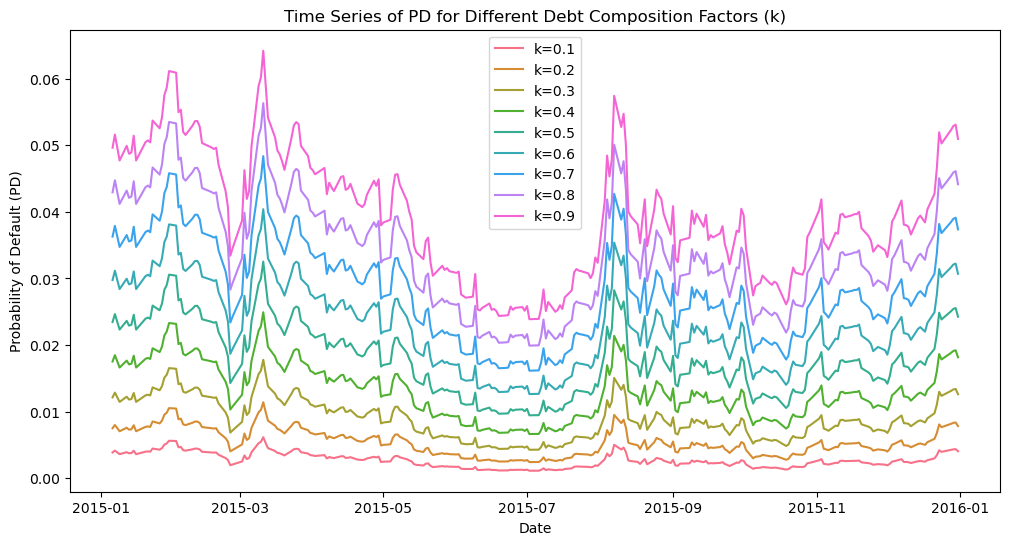

In [51]:
# visualizing the time series, x axis is dates, y axis is PD. Each line if for a different k
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Use seaborn color palette for consistency
palette = sns.color_palette("husl", len(k_values))

for i, k in enumerate(k_values):
    subset = results_df[results_df['k'] == k]
    plt.plot(subset['Date'], subset['PD'], label=f'k={k:.1f}', color=palette[i])

plt.xlabel('Date')
plt.ylabel('Probability of Default (PD)')
plt.title('Time Series of PD for Different Debt Composition Factors (k)')
plt.legend()
plt.show()

In [ ]:
# Time varying volatility
